In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import glob
import os
from pathlib import Path
from plaid.evaluation import batch_rmsd_calculation, run_tmalign, RITAPerplexity, batch_rmspd_from_pdb_paths
from plaid.utils import extract_avg_b_factor_per_residue, read_sequences_from_fasta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sample_dir = Path("/data/lux70/plaid/artifacts/samples/scaling")

In [84]:
hparam_tbl = pd.read_csv("plaid_hyperparameters.csv")
hparam_tbl = hparam_tbl[hparam_tbl.ID.isin(set(dfs.keys()))]
hparam_tbl = hparam_tbl.sort_values(by="Runtime",ascending=False)

print(hparam_tbl.shape)
hparam_tbl

(11, 199)


,Name,ID,Runtime,cfg.trainable_params_millions,cfg.denoiser.attention_mode,cfg.denoiser.max_seq_len,cfg.denoiser.use_skip_connect,cfg.trainer.gradient_clip_val,cfg.trainer.precision,cfg.denoiser.hidden_size,...,sample.model_ckpt_dir,sample.model_id,sample.num_samples,sample.organism_idx,sample.output_root_dir,sample.return_all_timesteps,sample.sample_scheduler,sample.sampling_timesteps,wandb_project_name,sample_latent_time
0,UDiT_B_AblationE2_skip,lqp25b7g,2049263,167.690752,xformers_memory_efficient,512,True,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UDiT_B_AblationE2,ksme77o6,1898234,134.021632,xformers_memory_efficient,512,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,L,4hdab8dn,1744688,898.006912,NaN,256,NaN,0.5,bf16-mixed,1280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UDiT_XXL,5j007z42,1508629,1762.218240,xformers_memory_efficient,256,False,0.5,32,2048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,Base,6ryvfi2v,563466,134.021504,NaN,512,NaN,0.5,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,AblationF__NoCondDrop,zlkurtdd,521517,134.021632,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,AblationD__A+predv+minsnr+sigmoid,93qqcdh9,521429,134.015264,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,AblationC__A+minsnr,oa5kjy9x,521414,134.015264,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,AblationA,ye1j29dh,521346,134.015264,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,AblationF__NoCondDrop,87up71bi,503728,134.021632,xformers_memory_efficient,256,False,1.0,32,768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
print(model_id)
hparam_tbl[hparam_tbl.ID == model_id]["cfg.trainable_params_millions"].values[0]

93qqcdh9


134.015264

In [92]:
dfs = {}

for model_id in os.listdir(sample_dir):
    tmp = []
    for l in [48, 100, 148]:
        df = pd.read_csv(sample_dir / model_id / str(l) / "designability.csv")
        df['model_id'] = [model_id] * len(df)
        # df['n_params'] = [hparam_tbl[hparam_tbl.ID == model_id]["cfg.trainable_params_millions"].values[0]] * len(df)
        # df['name'] = [hparam_tbl[hparam_tbl.ID == model_id]["Name"].values[0]] * len(df)
        # print(df.shape)
        tmp.append(df)
    df = pd.concat(tmp)
    if df.shape[0] > 0:
        dfs[model_id] = df

# for k, v in dfs.items():
#     print(k, v.shape)

In [95]:
big_df = pd.concat(list(dfs.values()))
print(big_df.shape)
big_df.head()

(2368, 19)


,Unnamed: 0,pdb_paths,sequences,inverse_generated_pdb_paths,phantom_generated_pdb_paths,plddt,ccrmsd,scrmsd,cctm,sctm,designable,perplexity,molecular_weight,aromaticity,instability_index,isoelectric_point,gravy,charge_at_pH,model_id
0,0,/data/lux70/plaid/artifacts/samples/scaling/ks...,LTSISVSDRALILESELDQWLHEAGAHPKEVLYRQKGIVDIPSAGD...,/data/lux70/plaid/artifacts/samples/scaling/ks...,/data/lux70/plaid/artifacts/samples/scaling/ks...,53.556247,2.225364,1.090029,0.89912,0.92328,False,18.512401,10934.2839,0.083333,28.566667,4.850776,-0.095833,-6.875829,ksme77o6
1,1,/data/lux70/plaid/artifacts/samples/scaling/ks...,ESVSIYMQTELKNAEAERIMDQIKSEPGVKAARYASKEEGLRRFQA...,/data/lux70/plaid/artifacts/samples/scaling/ks...,/data/lux70/plaid/artifacts/samples/scaling/ks...,58.013798,1.146107,2.468564,0.93783,0.75776,True,16.699188,10783.1615,0.062500,47.844896,5.450825,-0.566667,-1.146713,ksme77o6
2,2,/data/lux70/plaid/artifacts/samples/scaling/ks...,SYLVVSMLLFAIGAFGLMVRRNVIAIMSAIELLLAAINIDLVAFSR...,/data/lux70/plaid/artifacts/samples/scaling/ks...,/data/lux70/plaid/artifacts/samples/scaling/ks...,78.145488,2.058794,1.847329,0.93326,0.93018,False,7.871273,10382.3446,0.072917,38.213542,6.498254,1.181250,-0.443943,ksme77o6
3,3,/data/lux70/plaid/artifacts/samples/scaling/ks...,TNVWTHFAILTLLIPVIYHLVDKQNLLFLFFINGIAFALTNHILLR...,/data/lux70/plaid/artifacts/samples/scaling/ks...,/data/lux70/plaid/artifacts/samples/scaling/ks...,55.283909,2.261339,4.100365,0.86520,0.76552,False,15.950338,10830.7478,0.135417,45.784375,8.246941,1.064583,0.666234,ksme77o6
4,4,/data/lux70/plaid/artifacts/samples/scaling/ks...,AFETDSTTLDPTSARQLSNLISALQHAPNLMAELTGHVDAAGSAAA...,/data/lux70/plaid/artifacts/samples/scaling/ks...,/data/lux70/plaid/artifacts/samples/scaling/ks...,63.189855,1.025460,6.188116,0.94595,0.76719,True,9.974627,9869.8489,0.010417,28.618750,6.037631,-0.186458,-1.838074,ksme77o6


In [94]:
big_df.merge(hparam_tbl, on="ID")

KeyError: 'ID'

In [67]:
scaling = ["6ryvfi2v", "4hdab8dn", "5j007z42"]

In [61]:
list(dfs.values())[0].columns

Index(['Unnamed: 0', 'pdb_paths', 'sequences', 'inverse_generated_pdb_paths',
       'phantom_generated_pdb_paths', 'plddt', 'ccrmsd', 'scrmsd', 'cctm',
       'sctm', 'designable', 'perplexity', 'molecular_weight', 'aromaticity',
       'instability_index', 'isoelectric_point', 'gravy', 'charge_at_pH'],
      dtype='object')

In [70]:
def get_stat(df_dict, stat, model_id):
    tmp = df_dict[model_id]
    return tmp[stat].mean(), tmp[stat].std()

mean_plddts = [get_stat(dfs, "plddt", model_id)[0] for model_id in scaling]
mean_ccrmsds = [get_stat(dfs, "ccrmsd", model_id)[0] for model_id in scaling]
mean_perps = [get_stat(dfs, "perplexity", model_id)[0] for model_id in scaling]
std_plddts = [get_stat(dfs, "plddt", model_id)[1] for model_id in scaling]
std_ccrmsds = [get_stat(dfs, "ccrmsd", model_id)[1] for model_id in scaling]
std_perps = [get_stat(dfs, "perplexity", model_id)[1] for model_id in scaling]

/tmp/ipykernel_47471/1654228707.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaling,rotation=90)
/tmp/ipykernel_47471/1654228707.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaling,rotation=90)
/tmp/ipykernel_47471/1654228707.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaling,rotation=90)


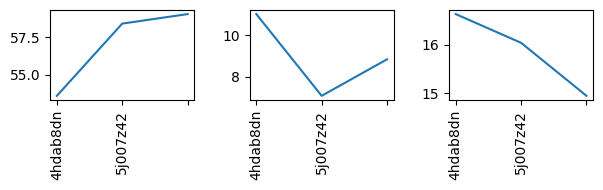

In [81]:
fig, axs = plt.subplots(1,3, figsize=(6,2))
axs[0].plot(mean_plddts,)
axs[1].plot(mean_ccrmsds)
axs[2].plot(mean_perps)


for ax in axs:
    ax.set_xticklabels(["])
plt.tight_layout()
plt.show()

In [82]:
scaling

['6ryvfi2v', '4hdab8dn', '5j007z42']